***
# <font> Exploratory Data Analysis on Diabetes Dataset</font>
<p style="margin-left:10%; margin-right:10%;"> <font color=teal> 

***

## Overview of this Notebook
The most important element in any data science project is the data itself. It is extremely important that this data is as clear as possible, so that we do not misinterpret any structure inherent to the problem.  
Data Preparations for training a Machine Learning model involves Data Transformations and Manipulations. This step is a very important step and takes typically 80% of the time in the entire life cycle of a Machine Learning Model. The real world data is mostly incomplete, and has several missing values. Missing values can be because of the unavailability of data or inconsistancy present in the data. There might be several errors and outliers present in the data. 
Preprocessing of data involves various steps
1. Combining attributes or columns  
2. Data Imputation
3. Data Cleaning
4. Dummy Variables Encoding
5. Outlier Detection
6. Feature Scaling
7. Feature Engineering
8. Feature Selection
9. Feature Extration.

This notebook will demonstrate the core functionality of the Dataset Factory class. In this notebook, you will learn some of the many ways to clean and transform data in an `ADSDatasetFactory` Object.
When datasets are loaded with DatasetFactory, they can be transformed and manipulated easily with the built-in functions. Underlying, an ADSDataset object is a Pandas dataframe. Any operation that can be performed to a Pandas dataframe can also be applied to an ADS Dataset.


First the necessary imports are made. From ads, DatasetBrowser, dataset factory, feature_engineering are imported. pandas, numpy packages are also imported. From plots matplotlib.pyplot is imported.

Please select the  pubhished conda envionment data-science-gmlv1_0_v1 before proceeding further. 

In [32]:
import ads
import io
import joblib 
import logging
import numpy as np  
import os
import pandas as pd
import sys 
import warnings
import tempfile

from ads.common.model import ADSModel
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads.dataset.factory import DatasetFactory
from ads.dataset.label_encoder import DataFrameLabelEncoder
from ads.evaluations.evaluator import ADSEvaluator
from collections import defaultdict
from os import path 
from os.path import expanduser
from os.path import join
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import get_scorer
from ads.common.model_artifact import ModelArtifact
from ads.config import NB_SESSION_OCID
from ads.config import PROJECT_OCID
from ads.config import NB_SESSION_COMPARTMENT_OCID

from ads.model.framework.sklearn_model import SklearnModel

ads.set_auth(auth='resource_principal') 

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

In [2]:
ads.hello()



  O  o-o   o-o
 / \ |  \ |
o---o|   O o-o
|   ||  /     |
o   oo-o  o--o

ads v2.8.9
oci v2.112.0
ocifs v1.2.1




The latest ads version installed is double checked. 

In [3]:
diab = pd.read_csv("diabetes.csv")

Diabetes dataset is downloaded as a csv file from <here> https://www.kaggle.com/datasets/mathchi/diabetes-data-set </here>
In this example, the csv file is read in a pandas core framework. This can be checked by viewing the type of dataset

In [4]:
type(diab) 

pandas.core.frame.DataFrame

In [5]:
ds = DatasetFactory.from_dataframe(pd.DataFrame(diab), target = 'Outcome')

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
type(ds)

ads.dataset.classification_dataset.BinaryClassificationDataset

The ADSDataset object cannot be used for classification or regression problems until a target has been set using set_target. The ds is of type Binary Classification Dataset. 

In [7]:
ds.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
ds.shape

(768, 9)

The diabetes dataset has 9 attributes and 768 rows. The number of Pregancies, Glucose level, BloodPressure, SkinThickness, Insulin amount taken, DiabetesPedigreeFunction, Age and based on these attributes the outcome is whether the person is diabetic or not. 

In [8]:
type(ds)

ads.dataset.classification_dataset.BinaryClassificationDataset

Since the dataset is a binaryClassification dataset it is converted from pandas to Dataframe 

The target output is outcome which indicates the presence or absence of diabetes based on input features

In [9]:
ds.summary()

,Feature,Datatype
0,Outcome,categorical/int64
1,Pregnancies,ordinal/int64
2,Glucose,ordinal/int64
3,BloodPressure,ordinal/int64
4,SkinThickness,ordinal/int64
5,Insulin,ordinal/int64
6,BMI,continuous/float64
7,DiabetesPedigreeFunction,continuous/float64
8,Age,ordinal/int64


This dataset has a combination of ordinal, continuous, categorial datatypes. Summary command helps to analyze the different datatypes present

In [11]:
diab.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

A check is made for the nullvalues using isna function and the diabetes dataset contains no null values

In [12]:
diab_without_dup = diab.drop_duplicates()
diab_without_dup.shape

(768, 9)

### Remove Duplicate Rows

Having duplicate rows is a pain, as it will slow down your model training, without any actual gain. And therefore, we need to remove duplicates. We can call the `drop_duplicates` function to return a dataset with all of the duplicates removed.

In [13]:
diab['Insulin'].isna().sum()

0

In [14]:
ds.show_in_notebook()

Loading BokehJS ...

Accordion(children=(HTML(value='<h1>Name: User Provided DataFrame</h1><h3>Type: BinaryClassificationDataset</h…

ADS offers a smart visualization tool that automatically detects the type of your data columns and offers the best way to plot your data. You can also create custom visualizations with ADS by using your preferred plotting libraries and packages. The correlation plot gives an idea on totally correlated pairwise attributes. Highly correlated attributes contribute less to decision making. So it is better to avoid those attributes. So the tranformed dataset ensures that such attributes are avoided. The drop column feature drops those columns which are correlated. Show_in_notebook() shows these correlations in the form of heatmaps. 
The ADS show_in_notebook() method creates a comprehensive preview of all the basic information about a dataset including:

a. The predictive data type (for example, regression, binary classification, or multinomial classification).

b. The number of columns and rows.

c. Feature type information.

d. Summary visualization of each feature.

e. The correlation map.

f. Any warnings about data conditions that you should be aware of.

To improve plotting performance, the ADS show_in_notebook() method uses an optimized subset of the data. This smart sample is selected so that it is statistically representative of the full dataset. The correlation map is only displayed when the data only has numerical (continuous or oridinal) columns.
The warnings in this case is the presence of null values for pregancies, insulin, skinthickness and outcome. This can be ignored because for this dataset this is not indicative of missing values.
The show_in_notebook() option shows 4 warnings. Pregnancies, SkinThicknes, Insulin, Outcome has zeros. Out of this, Outcome is the target variable. The other 3 attributes are just categorical which displays the presence or absence of Pregnancies, Insulin usage and SkinThickness. So this warning can be ignorned

In [17]:
ds.get_recommendations()

In [18]:
ds.select_best_features()

Outcome,Glucose,BMI,Age,Pregnancies,DiabetesPedigreeFunction,Insulin,SkinThickness,BloodPressure
1,148,33.600000,50,6,0.627000,0,35,72
0,85,26.600000,31,1,0.351000,0,29,66
1,183,23.300000,32,8,0.672000,0,0,64
0,89,28.100000,21,1,0.167000,94,23,66
1,137,43.100000,33,0,2.288000,168,35,40


BinaryClassificationDataset(target: Outcome) 768 rows, 9 columns

## Automated Transformations
ADS has built in automatic transform tools for datasets. When the get_recommendations() tool is applied to an ADSDataset object, it shows the user detected issues with the data and recommends changes to apply to the dataset. You can accept the changes is as easy as clicking a button in the drop down menu. After all the changes are applied, the transformed dataset can be retrieved by calling get_transformed_dataset().

In [19]:
ds.auto_transform()

loop1:   0%|          | 0/7 [00:00<?, ?it/s]

Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
1,6,148,72,35,0,33.600000,0.627000,50
0,1,85,66,29,0,26.600000,0.351000,31
1,8,183,64,0,0,23.300000,0.672000,32
0,1,89,66,23,94,28.100000,0.167000,21
1,0,137,40,35,168,43.100000,2.288000,33


BinaryClassificationDataset(target: Outcome) 768 rows, 9 columns

The auto_transform function returns transformed dataset with several optimizations applied automatically. The optimizations include:

1. Dropping constant and primary key columns, which has no predictive quality.
2. Imputation, to fill in missing values in noisy data.
3. For continuous variables, fill with mean if less than 40% is missing, else drop.
4. For categorical variables, fill with most frequent if less than 40% is missing, else drop.
5. Dropping strongly co-correlated columns that tend to produce less generalizable models.
6. Balancing dataset using up or down sampling.

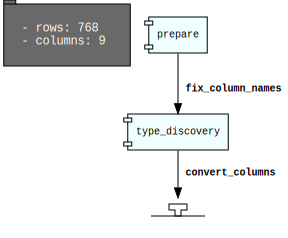

In [20]:
ds.visualize_transforms()

You can visualize the transformation that has been performed on a dataset by calling visualize_transforms().   

The preprocessed data is then used for training the machine learning model 

# Building and Visualizing Models

`ADS` also provides the ability to split a dataset into training and testing datasets using the `train_test_split` method and `train`  a set of models.

Next, you build a `sklearn` random forest model, and then use it with `ADS`.

In [21]:
train, test = ds.train_test_split()

In [23]:
class DataFrameLabelEncoder(TransformerMixin):
    def __init__(self):
        self.label_encoders = defaultdict(LabelEncoder)
        
    def fit(self, X):
        for column in X.columns:
            if X[column].dtype.name  in ["object", "category"]:
                self.label_encoders[column] = OrdinalEncoder()
                self.label_encoders[column].fit(X[column])
        return self
    
    def transform(self, X):
        for column, label_encoder in self.label_encoders.items():
            X[column] = label_encoder.transform(X[column])
        return X

le = DataFrameLabelEncoder()
X = le.fit_transform(train.X.copy())
y = train.y.copy()
sk_clf = RandomForestClassifier(random_state=42)
sk_clf.fit(X, y)
# Build an ADS model.
my_model = ADSModel.from_estimator(make_pipeline(le, sk_clf), 
                                   name=sk_clf.__class__.__name__)

In [30]:
print("Random Forest accuracy on test data:", my_model.score(test.X, test.y))

Random Forest accuracy on test data: 0.6883116883116883


Let's generate another model to compare the random forest to, in this case, we can use the more simple `DecisionTreeClassifier` as a baseline

In [33]:
dt_clf = DecisionTreeClassifier(random_state = 42)
dt_clf.fit(X, y)

my_other_model = ADSModel.from_estimator(make_pipeline(le, dt_clf), 
                                   name=dt_clf.__class__.__name__)

In [34]:
print("Decision tree accuracy on test data:", my_other_model.score(test.X, test.y))

Decision tree accuracy on test data: 0.7922077922077922



# Evaluating Models using `ADSEvaluator`

One of the key advantages of `ADS` is the ability to quickly evaluate any models. `ADS` supports evaluating:

- Regression
- Binary classification
- Multiclass classification

`ADS` allows you to provide your own evaluation function (given `y_true` and `y_pred` series) for any esoteric calculation that you want to run.

Next, you examine the plots that are commonly used to evaluate model performance. These include the precision-recall, ROC, lift, and gain plots. Each model under study is plotted together. This allows for easy comparison. In addition, the normalized confusion matrices are provided.

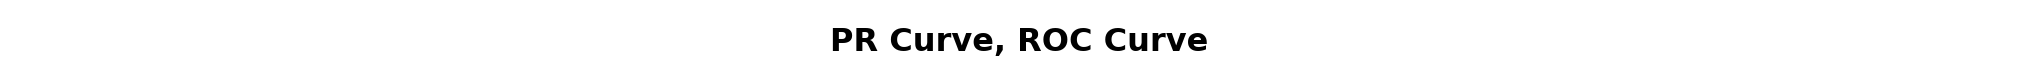

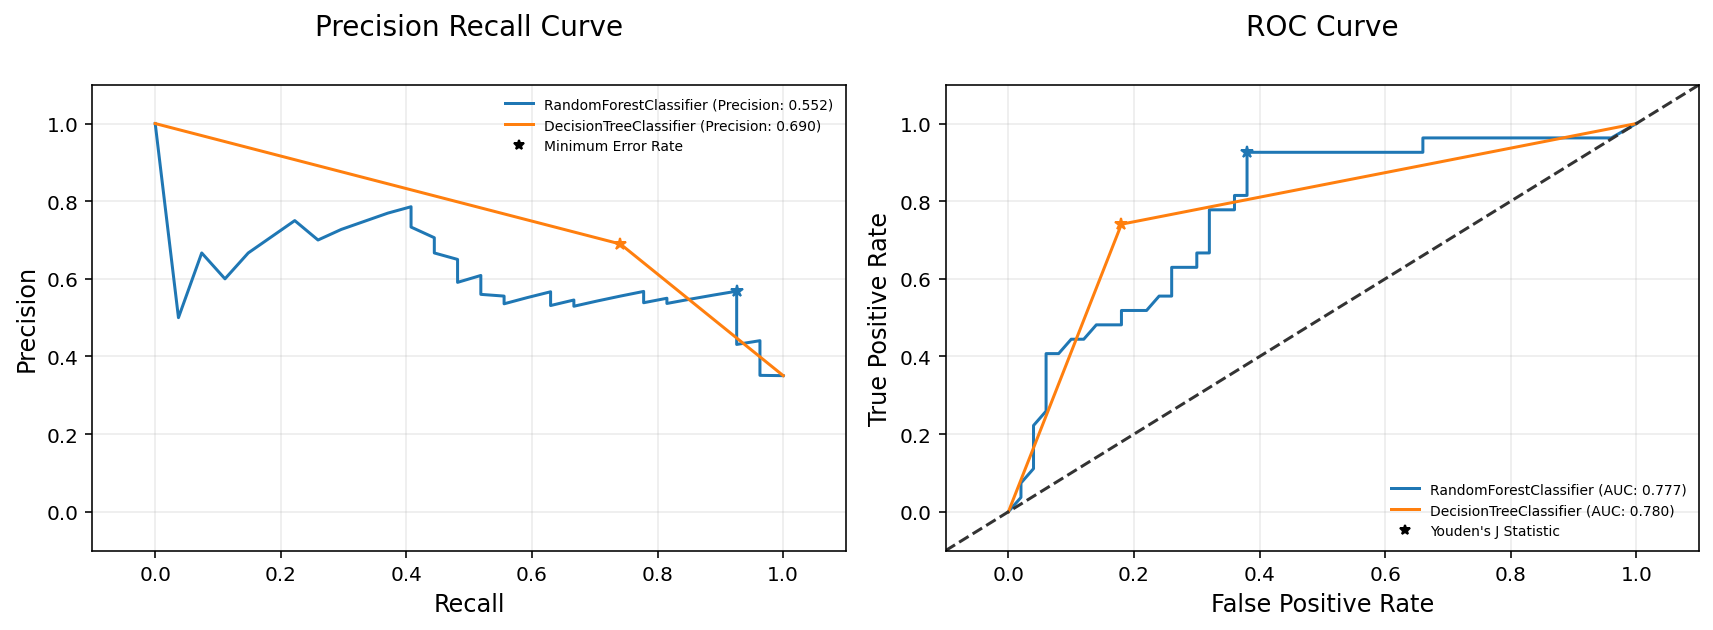

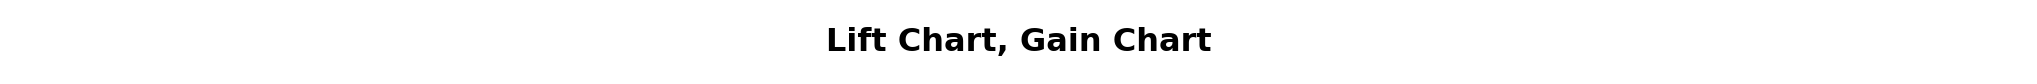

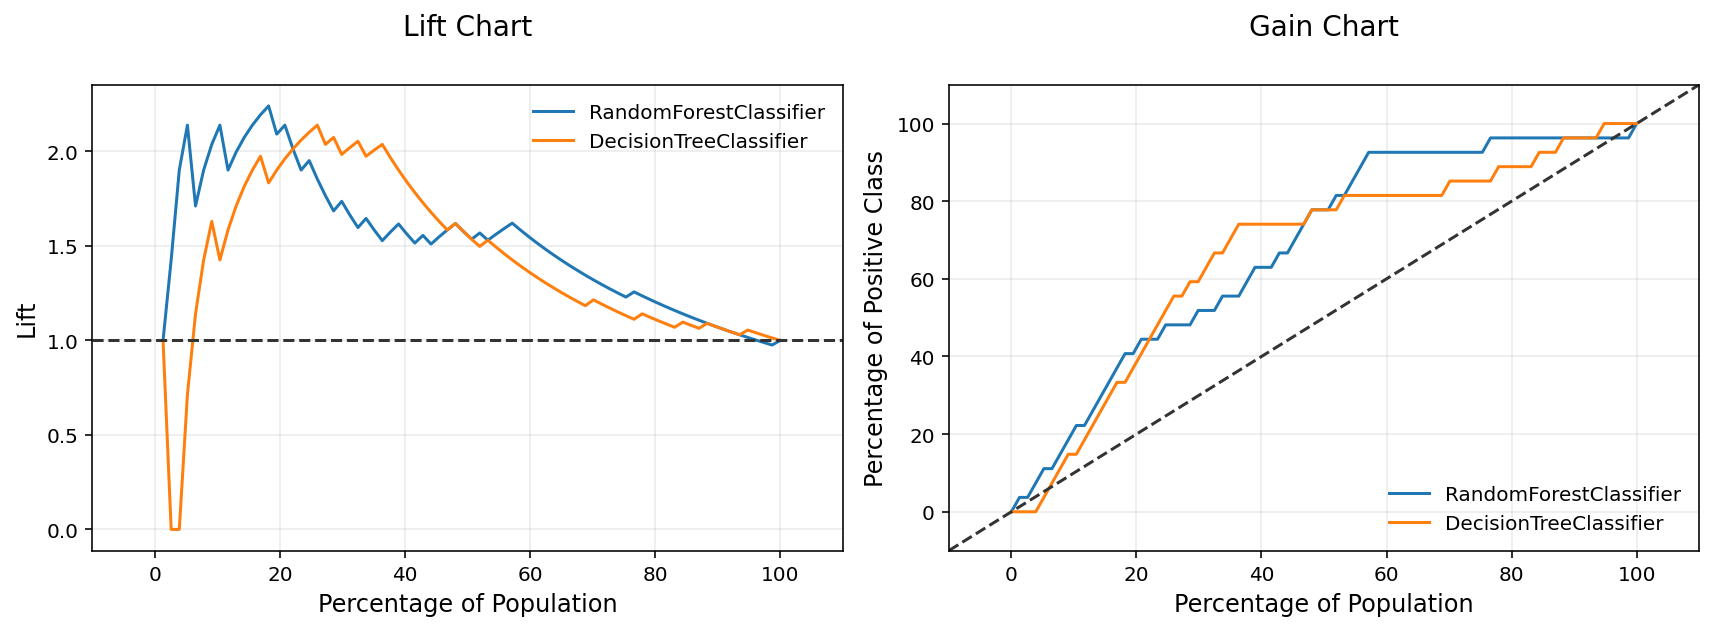

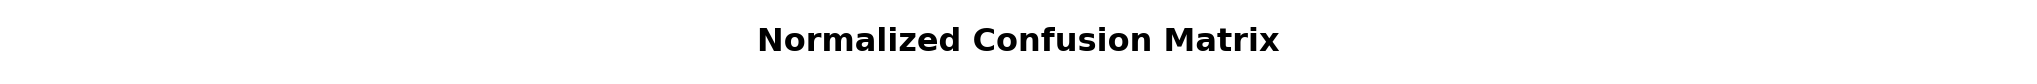

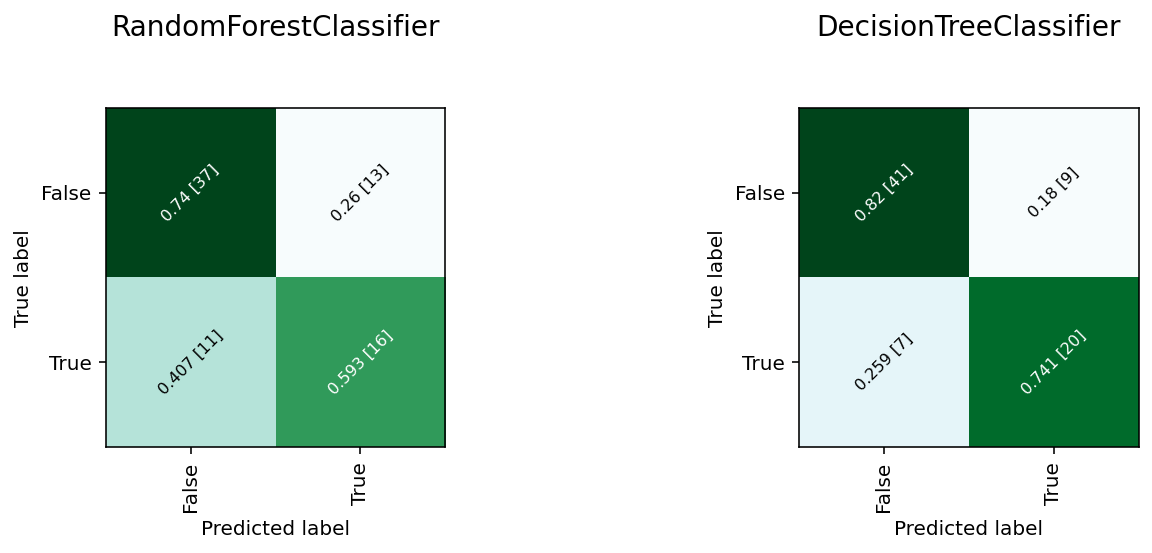

In [35]:
evaluator = ADSEvaluator(test, models=[my_model, my_other_model], 
                         training_data=train,
                         show_full_name=True,
                         positive_class=True)
evaluator.show_in_notebook()

There are a number of common metrics that are used to assess the quality of a model. `ADS` provides a convenient method to compare the models and highlights the model with the highest score in each metric.

Performance on training data doesn't tell you how the model performs on unseen data. You should look to performance on the `test` dataset to get an idea of which model is better

In [36]:
evaluator.metrics

,RandomForestClassifier,DecisionTreeClassifier
Accuracy,0.6883,0.7922
Hamming distance,0.3117,0.2078
Precision,0.5517,0.6897
Recall,0.5926,0.7407
F1,0.5714,0.7143
ROC AUC,0.7770,0.7804


,RandomForestClassifier,DecisionTreeClassifier
Accuracy,1.0000,1.0000
Hamming distance,0.0000,0.0000
Precision,1.0000,1.0000
Recall,1.0000,1.0000
F1,1.0000,1.0000
ROC AUC,1.0000,1.0000


A binary classification model can have one of four outcomes for each prediction. A true negative is an outcome where the model correctly predicts the negative case. For this example, that would be the case when the employee is predicted to leave. A false positive is when the model incorrectly predicts that an employee would stay and they do not. However, not all predictions may have the same importance. For example, a cancer test has a higher cost when it incorrectly says that a patient does not have cancer when they do. The `calculate_cost` method allows the cost to be computed for each model based on the cost of each class of prediction.

In [37]:
evaluator.calculate_cost(tn_weight=1, fp_weight=3, fn_weight=2, tp_weight=2)

,model,cost
0,RandomForestClassifier,130
1,DecisionTreeClassifier,122
